In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window, visualize_score_map
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor
from matcher import CnnMatcher, Window
from image import load_image
from feature_extractor import CNN, ReCNN, ResizeImageFeatureExtractor, FeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer, Scorer
from shape.basic import Size
from utils.timer import timer

def visualize_result(img: np.ndarray, score_map: np.ndarray, threshold: float, rois: Candidates, best_window: Window, scores: torch.Tensor):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img)
    axes[1].imshow(score_map)
    axes[2].imshow(score_map > threshold)

    windows = rois.rois.cpu().numpy()
    best_pos_indices = (windows[:, 1] == best_window.cx) & (windows[:, 2] == best_window.cy)
    best_pos_windows = windows[best_pos_indices]
    best_pos_scores = scores.reshape(-1)[best_pos_indices].cpu().numpy()
    angles = best_pos_windows[:, 5]
    axes[3].plot(angles, best_pos_scores)
    axes[3].set_xlabel('angle')
    axes[3].set_ylabel('score')
    axes[3].set_ylim(0.0, 1.0)
    plt.show()

Text(0.5, 1.0, 'template')

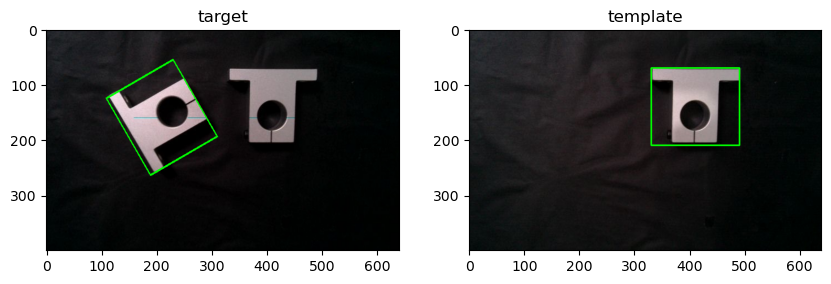

In [2]:
target_img = load_image('../data/image_1.png')
template_img = load_image('../data/template_1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

target_window = Window(210, 160, 160, 140, -120)
draw_img = draw_window(target_img, target_window)
axes[0].imshow(draw_img)
axes[0].set_title('target')

template_window = Window(410., 140., 160., 140., 0)
draw_img = draw_window(template_img, template_window)
axes[1].imshow(draw_img)
axes[1].set_title('template')

In [3]:
target_image_size = Size(*target_img.shape[:2])
template_size = template_window.get_size()
scales = [2, 4, 8, 16]

In [4]:
def evaluate(feature_extractor: FeatureExtractor, roi_feature_extractor: RoIAlignFeatureExtractor, scorer: Scorer, angle_step: int = 5):
    with timer('calc_cnn1'):
        template_feature_maps = feature_extractor(template_img)
    with timer('calc_cnn2'):
        target_feature_maps = feature_extractor(target_img)

    for idx, scale in enumerate(scales):
        rois = Candidates(template_size, target_image_size, angle_step=angle_step, x_step=scale, y_step=scale)
        with timer('calc_roi_features'):
            roi_features = roi_feature_extractor.extract(target_feature_maps[idx], rois.rois, spatial_scale=1.0/scale)

        template_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)
        # template_features = roi_feature_extractor.extract(target_feature_maps[idx], target_window, spatial_scale=1.0/scale)

        with timer('calc_scores'):
            scores = scorer.score(template_features, roi_features)
        best_score = scores.max()
        best_score_index = scores.argmax()

        num_steps = rois.get_num_steps()
        scores = scores.reshape(num_steps.y, num_steps.x, num_steps.angle)
        score_map = scores.max(-1).values.cpu().numpy()

        best_window = Window.from_array(rois[best_score_index])
        draw_img = draw_window(target_img, best_window)

        print(f'best score: {best_score:.4f} at {best_window}')
        visualize_result(draw_img, score_map, 0.8, rois, best_window, scores)

# CNN

map2  mean: 0.103 std: 0.122
map4  mean: 0.103 std: 0.122
map8  mean: 0.104 std: 0.123
map16 mean: 0.103 std: 0.118
Elapsed time for calc_cnn1           : 0.0244
map2  mean: 0.093 std: 0.173
map4  mean: 0.093 std: 0.174
map8  mean: 0.094 std: 0.174
map16 mean: 0.093 std: 0.174
Elapsed time for calc_cnn2           : 0.0013
Elapsed time for calc_roi_features   : 13.8241
Elapsed time for calc_scores         : 0.7762
best score: 0.9953 at Window(cx=410.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


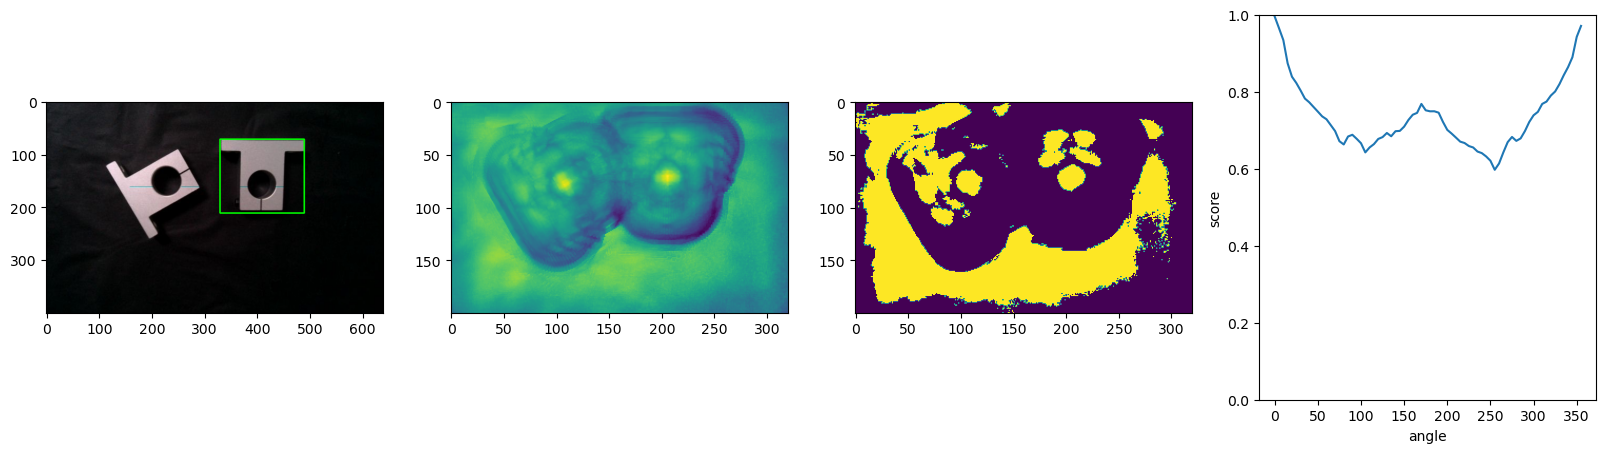

Elapsed time for calc_roi_features   : 3.2856
Elapsed time for calc_scores         : 0.1899
best score: 0.9879 at Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


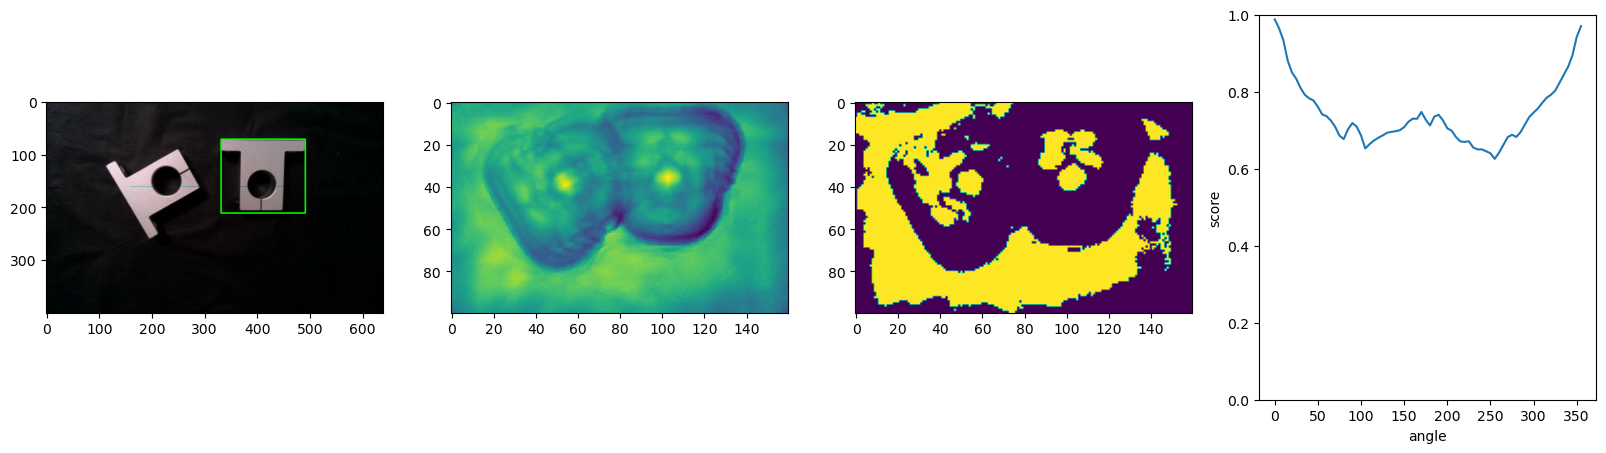

Elapsed time for calc_roi_features   : 0.8129
Elapsed time for calc_scores         : 0.0507
best score: 0.9848 at Window(cx=408.0, cy=136.0, width=160.0, height=140.0, angle=0.0)


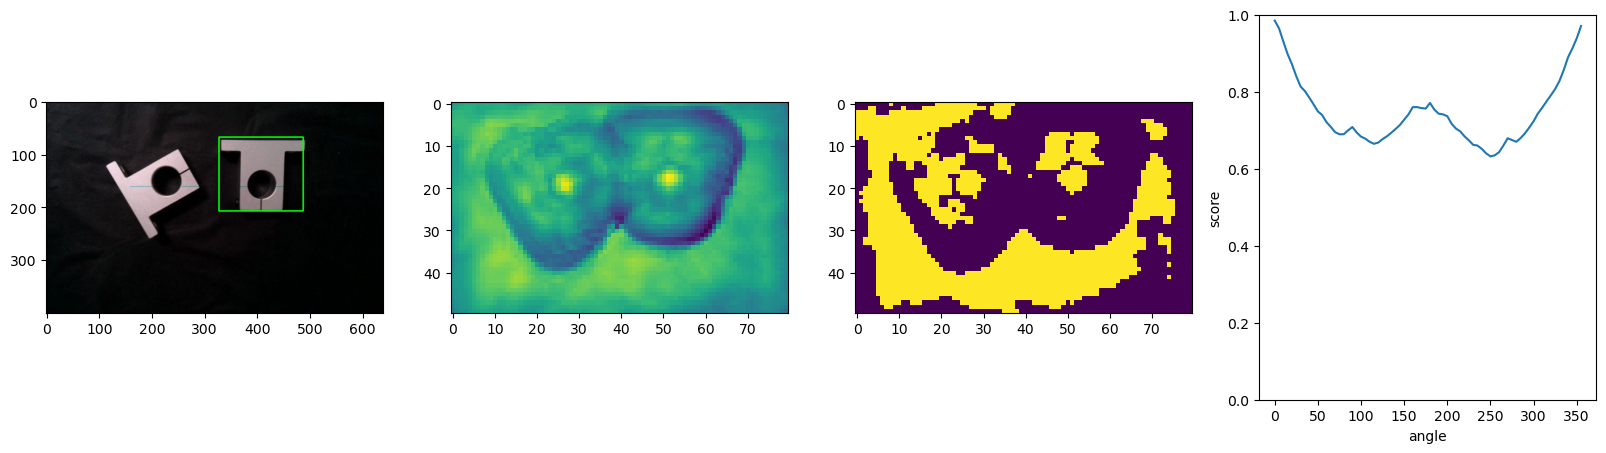

Elapsed time for calc_roi_features   : 0.2118
Elapsed time for calc_scores         : 0.0135
best score: 0.9620 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=0.0)


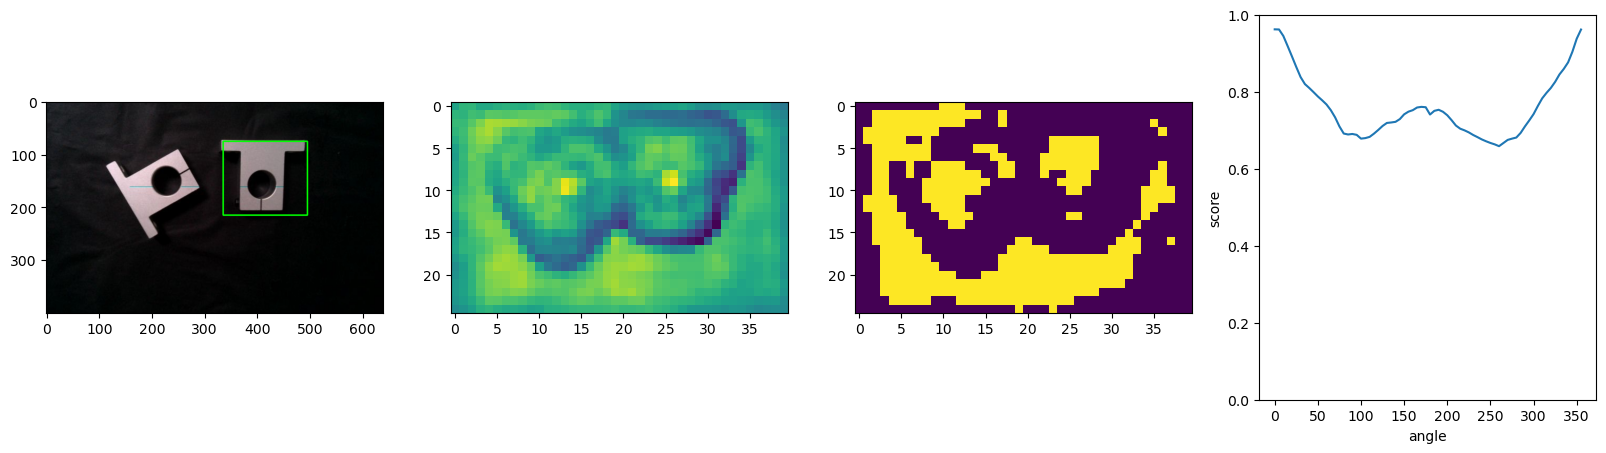

In [5]:
from feature_extractor import ResizeImageFeatureExtractor

feature_extractor = ResizeImageFeatureExtractor()
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=7, sampling_ratio=2)
scorer = CosineSimilarityScorer()
evaluate(feature_extractor, roi_feature_extractor, scorer, angle_step=5)

map2  mean: 1.278 std: 5.134
map4  mean: 0.978 std: 5.302
map8  mean: -0.431 std: 5.020
map16 mean: -0.119 std: 4.108
Elapsed time for calc_cnn1           : 0.7009
map2  mean: 1.369 std: 5.658
map4  mean: 0.964 std: 5.857
map8  mean: -0.466 std: 5.554
map16 mean: -0.190 std: 4.461
Elapsed time for calc_cnn2           : 0.0076
Elapsed time for calc_roi_features   : 0.1886
Elapsed time for calc_scores         : 0.4257
best score: 0.9398 at Window(cx=410.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


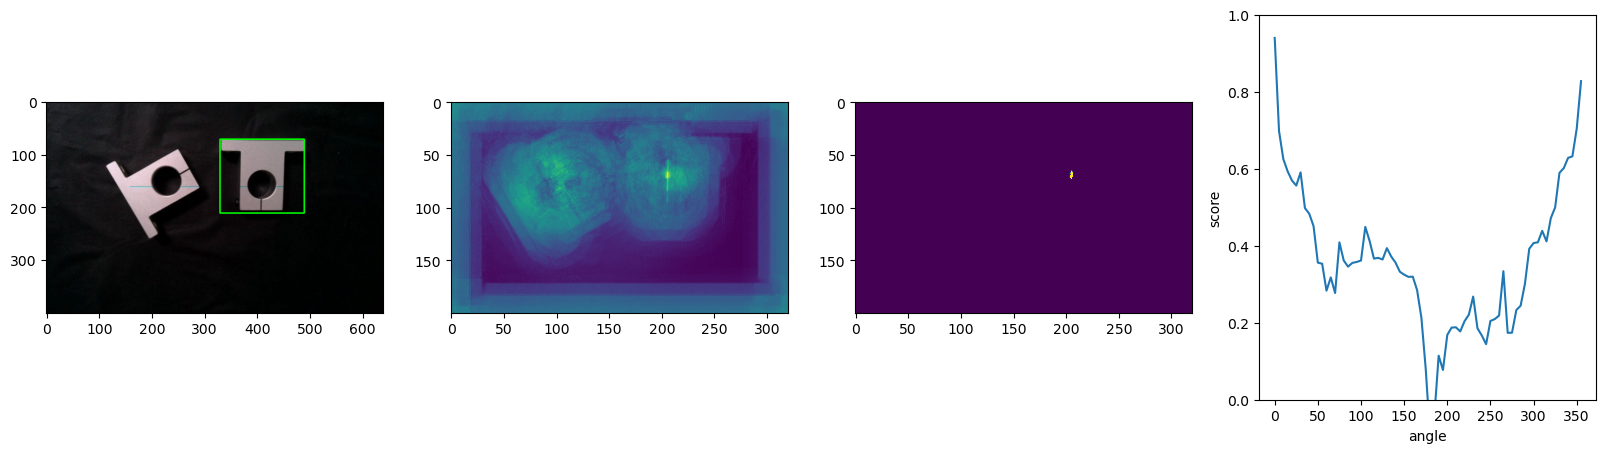

Elapsed time for calc_roi_features   : 0.0493
Elapsed time for calc_scores         : 0.0002
best score: 0.9168 at Window(cx=408.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


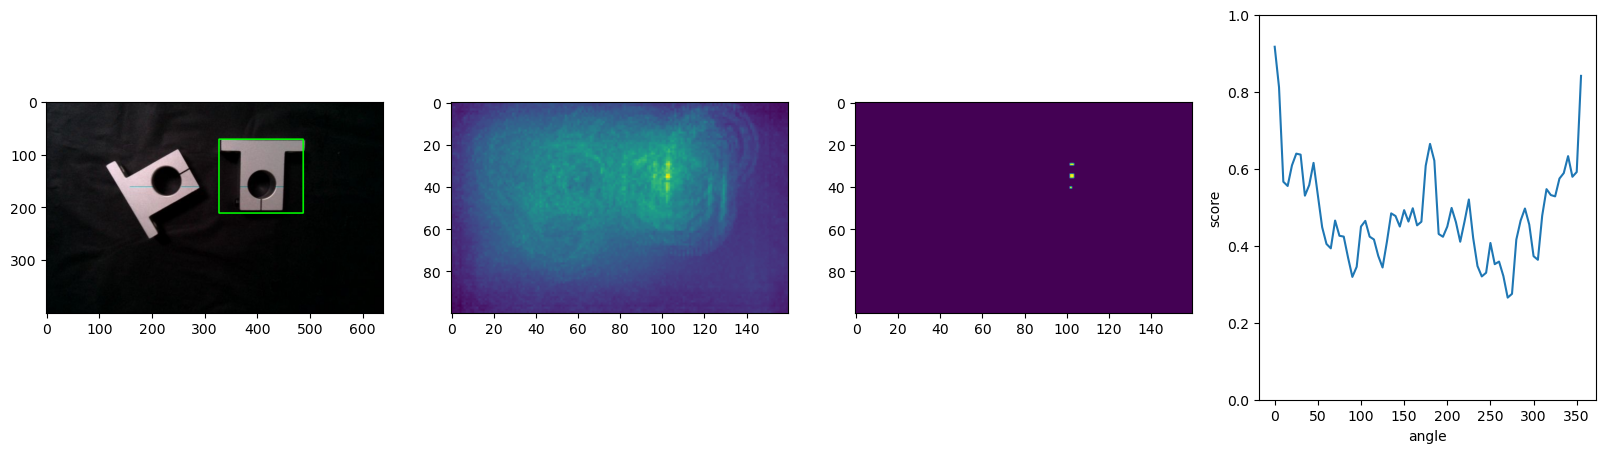

Elapsed time for calc_roi_features   : 0.0235
Elapsed time for calc_scores         : 0.0002
best score: 0.8153 at Window(cx=408.0, cy=136.0, width=160.0, height=140.0, angle=0.0)


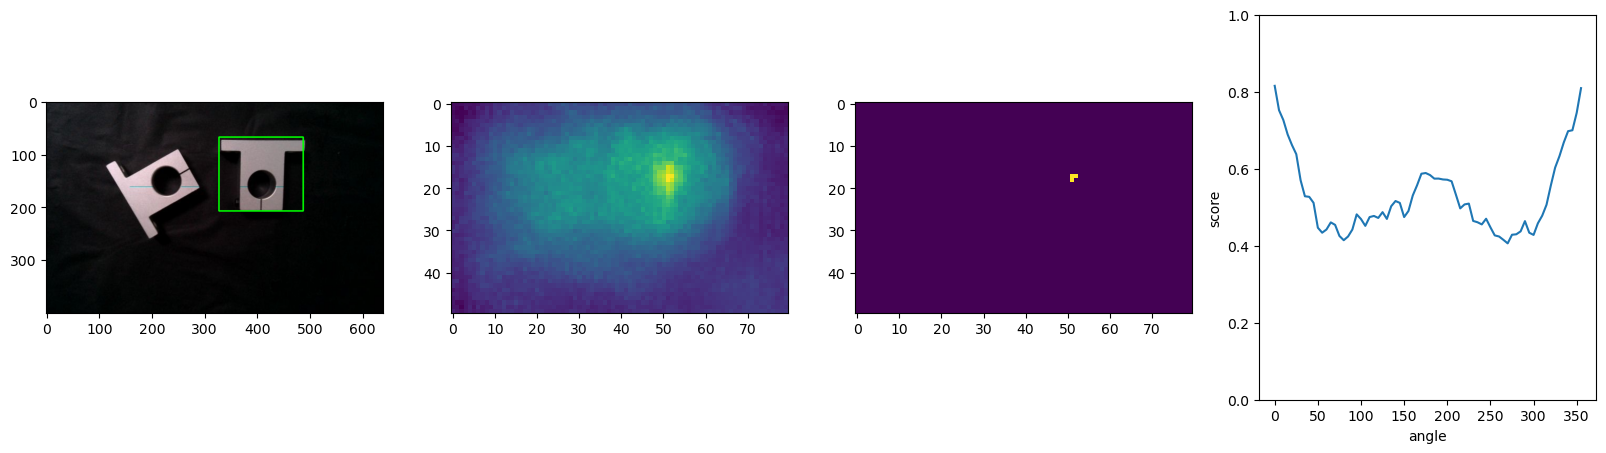

Elapsed time for calc_roi_features   : 0.0112
Elapsed time for calc_scores         : 0.0002
best score: 0.9005 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=5.0)


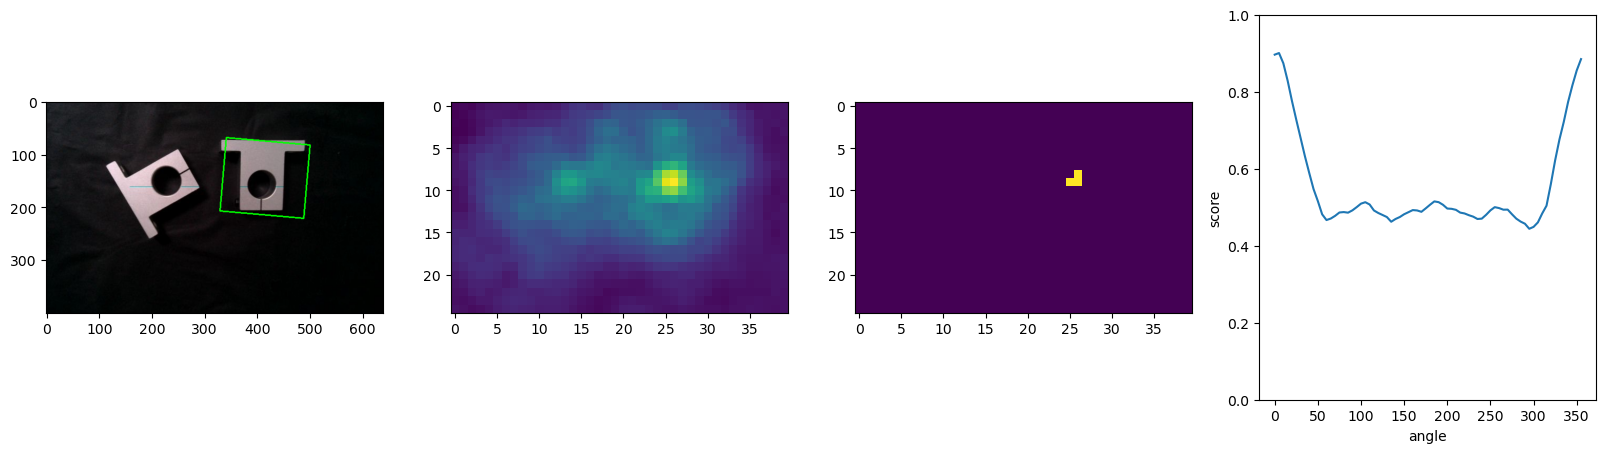

In [6]:
device='cuda'
feature_extractor = CNN(device=device, pretrained=True)
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2, device=device)
scorer = CosineSimilarityScorer()
evaluate(feature_extractor, roi_feature_extractor, scorer)

/opt/conda/lib/python3.7/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


map2  mean: 0.528 std: 0.507
map4  mean: 0.352 std: 0.328
map8  mean: 0.178 std: 0.353
map16 mean: 0.046 std: 0.336
Elapsed time for calc_cnn1           : 0.1783
map2  mean: 0.530 std: 0.525
map4  mean: 0.357 std: 0.342
map8  mean: 0.177 std: 0.372
map16 mean: 0.039 std: 0.355
Elapsed time for calc_cnn2           : 0.1575
Elapsed time for calc_roi_features   : 15.2623
Elapsed time for calc_scores         : 1.2610
best score: 0.9965 at Window(cx=410.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


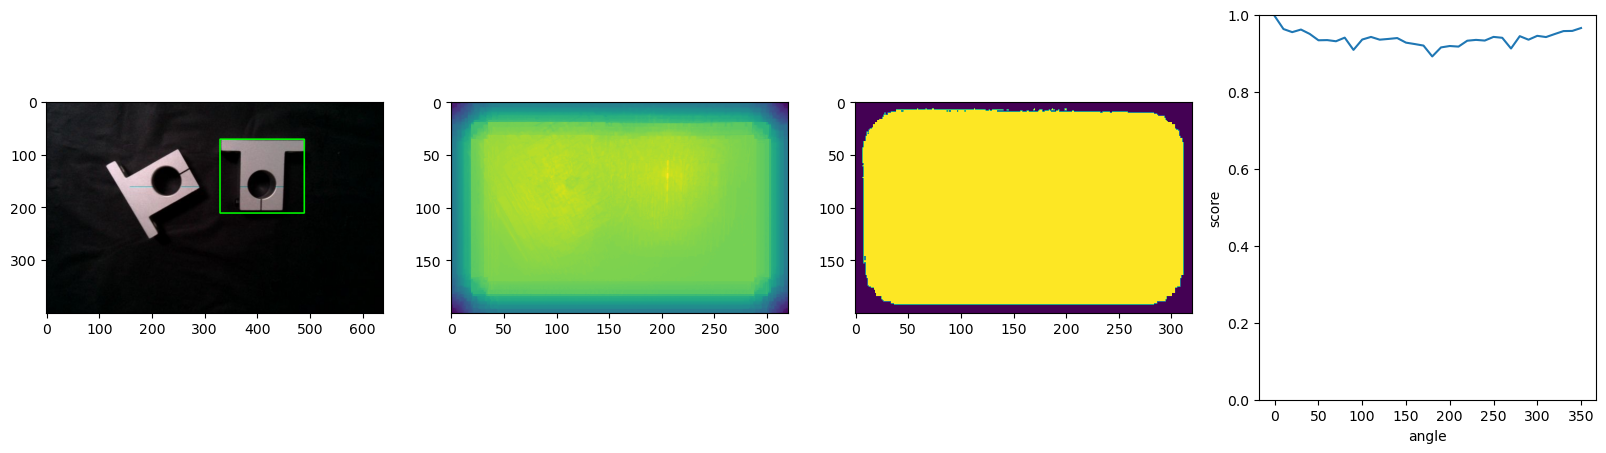

Elapsed time for calc_roi_features   : 14.4990
Elapsed time for calc_scores         : 1.1091
best score: 0.9721 at Window(cx=408.0, cy=140.0, width=160.0, height=140.0, angle=0.0)


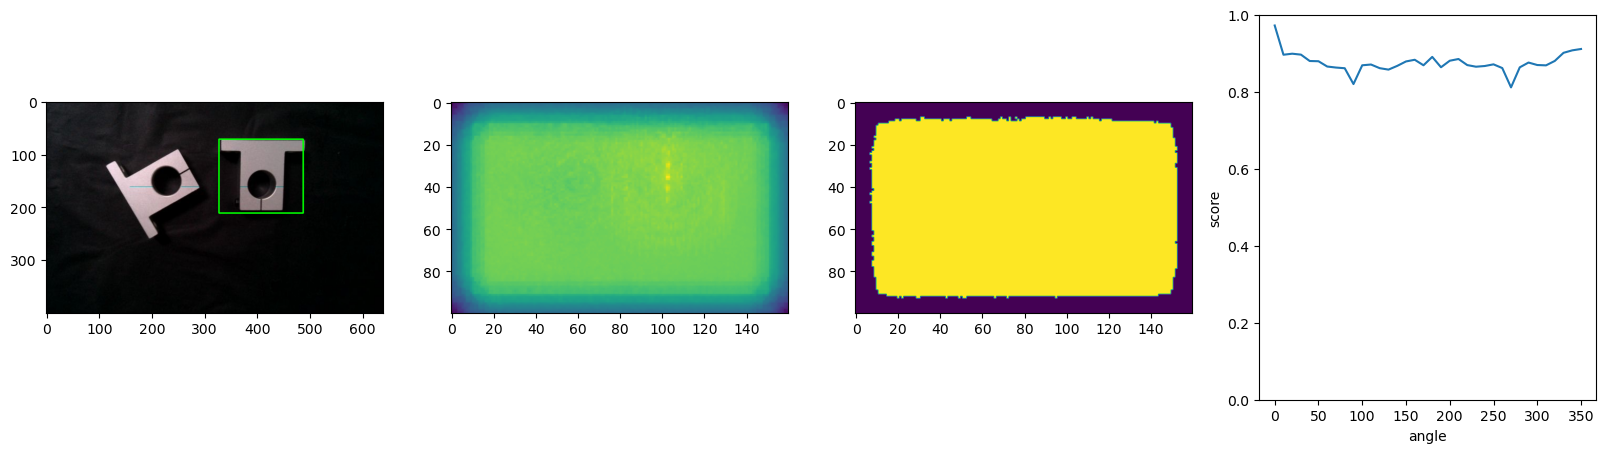

Elapsed time for calc_roi_features   : 6.5265
Elapsed time for calc_scores         : 0.5444
best score: 0.9360 at Window(cx=408.0, cy=144.0, width=160.0, height=140.0, angle=0.0)


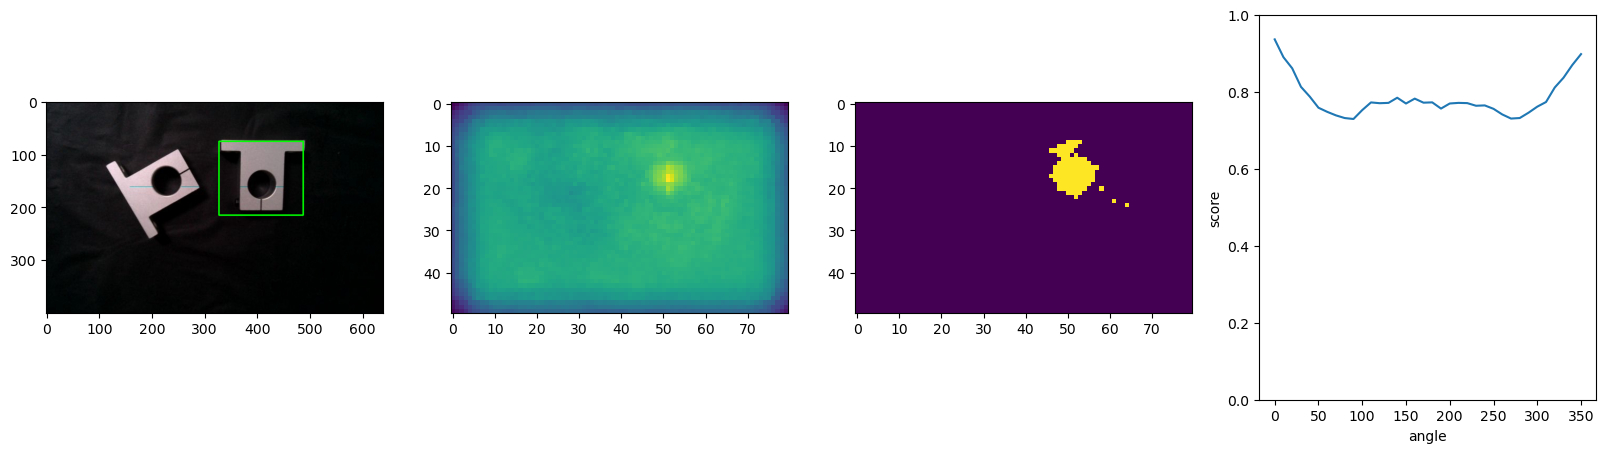

Elapsed time for calc_roi_features   : 2.9840
Elapsed time for calc_scores         : 0.2792
best score: 0.9337 at Window(cx=416.0, cy=144.0, width=160.0, height=140.0, angle=0.0)


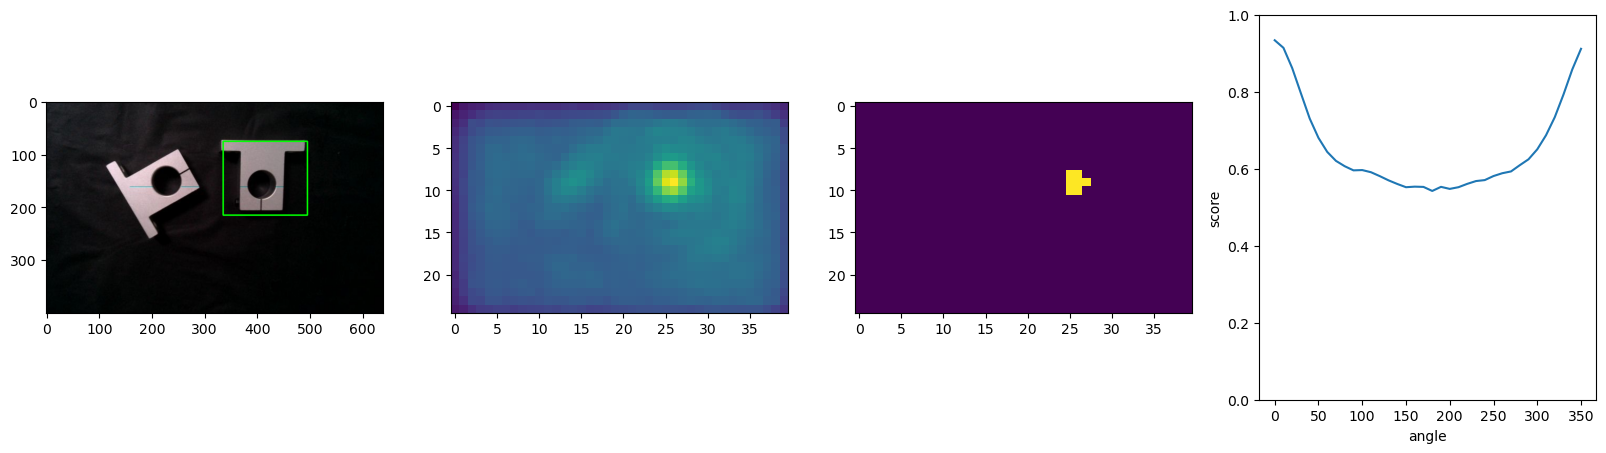

In [7]:
device='cpu'
feature_extractor = ReCNN(device=device)
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2, device=device)
scorer = CosineSimilarityScorer()
evaluate(feature_extractor, roi_feature_extractor, scorer, angle_step=10)

In [8]:
device='cpu'
feature_extractor = ReCNN(device=device)

angle_step = 5
with timer('calc_cnn1'):
    template_feature_maps = feature_extractor(template_img)
with timer('calc_cnn2'):
    target_feature_maps = feature_extractor(target_img)

map2  mean: 0.528 std: 0.507
map4  mean: 0.352 std: 0.328
map8  mean: 0.178 std: 0.353
map16 mean: 0.046 std: 0.336
Elapsed time for calc_cnn1           : 0.1501
map2  mean: 0.530 std: 0.525
map4  mean: 0.357 std: 0.342
map8  mean: 0.177 std: 0.372
map16 mean: 0.039 std: 0.355
Elapsed time for calc_cnn2           : 0.1568


In [12]:
np.set_printoptions(precision=3, suppress=True)

scales = [2, 4, 8, 16]
idx = 0
scale = scales[idx]
center = template_window.get_center(1.0/scale)
print(template_feature_maps[idx][0, :, center.cy, center.cx].reshape(-1, 8).cpu().numpy())

print()

center = target_window.get_center(1.0/scale)
print(template_feature_maps[idx][0, :, center.cy, center.cx].reshape(-1, 8).cpu().numpy())

[[ 0.949  0.931  0.931  0.936  0.957  0.987  0.98   0.964]
 [ 0.422  0.426  0.394  0.397  0.444  0.446  0.438  0.44 ]
 [ 0.146  0.16   0.212  0.196  0.13   0.117  0.149  0.138]
 [ 0.267  0.269  0.274  0.268  0.243  0.267  0.253  0.271]
 [-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
 [-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
 [ 1.45   1.493  1.551  1.532  1.526  1.534  1.545  1.499]
 [ 1.035  1.038  1.013  0.994  0.973  0.975  0.999  1.02 ]]

[[ 0.875  0.883  0.883  0.873  0.875  0.888  0.874  0.873]
 [ 0.336  0.404  0.452  0.576  0.457  0.382  0.481  0.395]
 [ 0.355  0.274  0.214  0.117  0.172  0.234  0.229  0.277]
 [ 0.261  0.257  0.11   0.17   0.26   0.213  0.188  0.253]
 [-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
 [-0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
 [ 1.44   1.491  1.444  1.433  1.416  1.31   1.303  1.336]
 [ 1.044  1.043  1.057  1.09   1.111  1.121  1.109  1.076]]
